[PROTECTED$11$](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [PROTECTED$12$](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)



# 筛选和精简消息（Filtering and trimming messages）

## 评论（Review）

Now, we have a deeper understanding of a few things: 

现在，我们对几件事情有了更深的理解：

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

*如何自定义图状态模式* 如何定义自定义状态还原函数  
* 如何使用多个图状态模式

## 目标（Goals）

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

现在，我们可以开始在 LangGraph 中的模型中使用这些概念！

在接下来的几节中，我们将逐步构建一个具有长期记忆的聊天机器人。

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

因为我们的聊天机器人将使用消息，所以让我们先更多地讨论一下在图形状态中处理消息的高级方法。



In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

我们将使用 [LangSmith](https://docs.smith.langchain.com/) 来处理 [tracing](https://docs.smith.langchain.com/concepts/tracing)。

We'll log to a project, `langchain-academy`. 

我们将记录到一个项目中，`langchain-academy`。



In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## 消息作为状态（Messages as state）

First, let's define some messages.

首先，让我们定义一些消息。



In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"所以你说你在研究海洋哺乳动物？", name="Bot")]
messages.append(HumanMessage(f"是的，我知道鲸鱼。但我还应该了解哪些其他的呢？", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

所以你说你在研究海洋哺乳动物？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的呢？


Recall we can pass them to a chat model.

回想一下，我们可以将它们传递给聊天模型。



In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    model="qwen-plus-2025-04-28",
    api_key="sk-ba2dda3817f145d7af141fdf32e31d90",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)
llm.invoke(messages)

AIMessage(content='太好了！你已经知道鲸鱼，那我们来扩展一下视野。海洋哺乳动物是一个非常多样化的群体，除了鲸鱼之外，还有很多有趣的种类。以下是一些你应该了解的其他主要类群：\n\n---\n\n### 一、鲸目（Cetacea）——你已经知道的鲸鱼家族\n鲸鱼是完全水生的海洋哺乳动物，分为两大类：\n\n- **须鲸类**（Mysticeti）：如蓝鲸、座头鲸、灰鲸，它们用鲸须板滤食磷虾。\n- **齿鲸类**（Odontoceti）：如抹香鲸、虎鲸、海豚、鼠海豚，它们有牙齿，捕食鱼类或海洋哺乳动物。\n\n---\n\n### 二、鳍足类（Pinnipedia）——“有鳍的脚”的哺乳动物\n\n这类动物在陆地上也能活动，但大部分时间生活在海洋中：\n\n1. **海豹**（Seals）：\n   - 没有外耳，用后鳍在水中推进。\n   - 常见种类：港海豹、威德尔海豹。\n\n2. **海狮**（Sea lions）：\n   - 有小耳朵，前鳍大，善于在陆地上行走。\n   - 常见种类：加州海狮、南美海狮。\n\n3. **海象**（Walruses）：\n   - 长有显著的獠牙，生活在北极地区。\n   - 用獠牙在冰上支撑身体，还能用来挖掘蛤蜊。\n\n---\n\n### 三、海獭（Sea otters）\n\n- 属于食肉目动物，是唯一几乎一生都在海中度过的鼬科动物。\n- 以海胆、贝类为食，会使用石头敲开贝壳。\n- 是生态系统中的“关键种”，有助于维持海藻森林的健康。\n\n---\n\n### 四、北极熊（Polar bears）\n\n- 虽然严格来说是陆地哺乳动物，但它们依赖海冰捕猎海豹，也常被视为海洋哺乳动物。\n- 被认为是“海洋哺乳动物的边缘种”。\n\n---\n\n### 五、海牛目（Sirenia）——温柔的“美人鱼”亲戚\n\n1. **海牛**（Manatees）：\n   - 生活在淡水和浅海，吃水草。\n   - 常被称为“美人鱼”的原型。\n\n2. **儒艮**（Dugongs）：\n   - 与海牛近缘，但只生活在海洋中。\n   - 主要分布在印度洋-太平洋沿岸，中国南部海域也曾有分布。\n\n---\n\n### 六、一些有趣的冷知识：\n\n- **鲸歌**：座头鲸等会发出复杂的声音进行交

We can run our chat model in a simple graph with `MessagesState`.

我们可以在一个简单的图中运行我们的聊天模型 `MessagesState`。



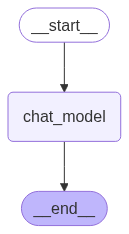

In [5]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

所以你说你在研究海洋哺乳动物？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的呢？
================================== Ai Message ==================================

太棒了！你对鲸鱼已经有所了解，那我们来拓展一下视野。海洋哺乳动物是一个多样化的群体，除了鲸鱼之外，还有许多其他有趣的种类。以下是一些你可能应该了解的主要类群：

---

### 一、鲸目（Cetacea）——包括鲸鱼和海豚

虽然你已经知道鲸鱼，但其实这个目下还包括海豚和鼠海豚。

- **须鲸类（Mysticeti）**：如蓝鲸、座头鲸、灰鲸，它们用鲸须板滤食磷虾。
- **齿鲸类（Odontoceti）**：如抹香鲸、虎鲸（其实是海豚科的）、中华白海豚、江豚等，它们有牙齿，捕食鱼类或头足类。
- **淡水鲸类**：比如亚马逊河豚、恒河豚、已经功能性灭绝的中国白鱀豚。

---

### 二、鳍足类（Pinnipedia）——包括海狮、海象、海豹

它们是能在陆地上活动的海洋哺乳动物，通常在陆地上繁殖、休息，但大部分时间在海中觅食。

- **海狮（Sea Lions）**：前肢发达，能在陆地上行走，声音大，常在动物园表演。
- **海豹（Seals）**：用腹部蠕动前进，更适应水中生活。
- **海象（Walruses）**：有长长的象牙，生活在北极地区。

---

### 三、海獭（Sea Otters）

- 唯一完全生活在海洋中的食肉目哺乳动物。
- 以海胆、蛤蜊等为食，使用石头敲开贝壳。
- 对维持海藻森林生态系统至关重要。

---

### 四、北极熊（Polar Bears）

虽然严格来说是陆生食肉动物，但北极熊也被归为海洋哺乳动物，因为它们依赖海冰狩猎海豹，长时间在海上活动。

---

### 五、海牛目（Sirenia）——包括海牛

## 简化器（Reducer）

A practical challenge when working with messages is managing long-running conversations. 
Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

如果我们在处理长时间对话时不够小心，会导致高令牌使用量和延迟，因为我们传递给模型的是一系列不断增加的消息。

We have a few ways to address this.

我们有几种方法可以解决这个问题。

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

首先，回想我们使用 `RemoveMessage` 和 `add_messages` 减少器看到的技巧。



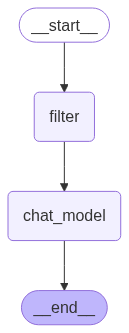

In [ ]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # 删除除最近两条消息外的所有消息
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("所以你说你在研究海洋哺乳动物？", name="Bot", id="3"))
messages.append(HumanMessage("是的，我知道鲸鱼。但我还应该了解哪些其他的呢？", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

所以你说你在研究海洋哺乳动物？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的呢？
================================== Ai Message ==================================

太棒了！你对鲸鱼已经有所了解，那我们可以一起扩展一下关于海洋哺乳动物的知识。除了鲸鱼之外，海洋哺乳动物还包括很多其他有趣的种类，以下是一些你可能应该了解的类别和代表性动物：

---

### 🐋 1. **鲸目（Cetacea）** – 你已经了解的鲸鱼就属于这一类

包括：
- **须鲸类（Mysticeti）**：如蓝鲸、座头鲸、灰鲸，它们用鲸须板过滤食物。
- **齿鲸类（Odontoceti）**：如抹香鲸、虎鲸（逆戟鲸）、海豚、鼠海豚。

💡 **小知识**：虽然“鲸”和“鱼”字一样，但它们不是鱼，而是哺乳动物，用肺呼吸，会哺育幼崽。

---

### 🦭 2. **鳍足类（Pinnipedia）** – 常见的海狮、海象、海豹

包括：
- **海狮（Sea Lions）**：耳朵有耳廓，可以在陆地上行走。
- **海豹（Seals）**：没有外耳，靠扭动身体移动。
- **海象（Walruses）**：有巨大的獠牙，主要生活在北极地区。

💡 **小知识**：这些动物大部分时间在水中生活，但必须上岸繁殖或休息。

---

### 🦦 3. **海獭（Sea Otters）**

- 属于食肉目，生活在北太平洋沿岸。
- 非常聪明，会使用石头敲开贝壳。
- 是少数会使用工具的海洋哺乳动物之一。

💡 **小知识**：它们的皮毛是哺乳动物中最密集的，靠皮毛保暖而不是脂肪层。

---

### 🐀 4. **海牛目（Sirenia）** – 温和的“美人鱼”亲戚

包括：
- **海牛（Manatees）**
- **儒艮（Dugongs）**


## 筛选消息（Filtering messages）

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

如果你不需要或不希望修改图状态，可以直接过滤传递给聊天模型的消息。

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

例如，只需传递一个过滤后的列表：`llm.invoke(messages[-1:])` 给模型。



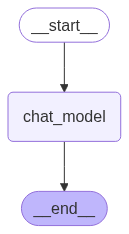

In [11]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

让我们取现有的消息列表，添加上述 LLM 响应，并附加一个后续问题。



In [12]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"告诉我更多关于独角鲸的信息！", name="Lance"))

In [13]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

所以你说你在研究海洋哺乳动物？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的呢？
================================== Ai Message ==================================

太棒了！你对鲸鱼已经有所了解，那我们可以一起扩展一下关于海洋哺乳动物的知识。除了鲸鱼之外，海洋哺乳动物还包括很多其他有趣的种类，以下是一些你可能应该了解的类别和代表性动物：

---

### 🐋 1. **鲸目（Cetacea）** – 你已经了解的鲸鱼就属于这一类

包括：
- **须鲸类（Mysticeti）**：如蓝鲸、座头鲸、灰鲸，它们用鲸须板过滤食物。
- **齿鲸类（Odontoceti）**：如抹香鲸、虎鲸（逆戟鲸）、海豚、鼠海豚。

💡 **小知识**：虽然“鲸”和“鱼”字一样，但它们不是鱼，而是哺乳动物，用肺呼吸，会哺育幼崽。

---

### 🦭 2. **鳍足类（Pinnipedia）** – 常见的海狮、海象、海豹

包括：
- **海狮（Sea Lions）**：耳朵有耳廓，可以在陆地上行走。
- **海豹（Seals）**：没有外耳，靠扭动身体移动。
- **海象（Walruses）**：有巨大的獠牙，主要生活在北极地区。

💡 **小知识**：这些动物大部分时间在水中生活，但必须上岸繁殖或休息。

---

### 🦦 3. **海獭（Sea Ot

In [14]:
#调用，使用消息过滤
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

所以你说你在研究海洋哺乳动物？
================================ Human Message =================================
Name: Lance

是的，我知道鲸鱼。但我还应该了解哪些其他的呢？
================================== Ai Message ==================================

太棒了！你对鲸鱼已经有所了解，那我们可以一起扩展一下关于海洋哺乳动物的知识。除了鲸鱼之外，海洋哺乳动物还包括很多其他有趣的种类，以下是一些你可能应该了解的类别和代表性动物：

---

### 🐋 1. **鲸目（Cetacea）** – 你已经了解的鲸鱼就属于这一类

包括：
- **须鲸类（Mysticeti）**：如蓝鲸、座头鲸、灰鲸，它们用鲸须板过滤食物。
- **齿鲸类（Odontoceti）**：如抹香鲸、虎鲸（逆戟鲸）、海豚、鼠海豚。

💡 **小知识**：虽然“鲸”和“鱼”字一样，但它们不是鱼，而是哺乳动物，用肺呼吸，会哺育幼崽。

---

### 🦭 2. **鳍足类（Pinnipedia）** – 常见的海狮、海象、海豹

包括：
- **海狮（Sea Lions）**：耳朵有耳廓，可以在陆地上行走。
- **海豹（Seals）**：没有外耳，靠扭动身体移动。
- **海象（Walruses）**：有巨大的獠牙，主要生活在北极地区。

💡 **小知识**：这些动物大部分时间在水中生活，但必须上岸繁殖或休息。

---

### 🦦 3. **海獭（Sea Ot

The state has all of the mesages.

状态包含了所有消息。

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

但是，让我们查看 LangSmith 跟踪记录，以确认模型调用仅使用最后一条消息：

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r



## 裁剪消息（Trim messages）

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

另一种方法是根据设定数量的令牌进行 [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens)。

This restricts the message history to a specified number of tokens.

这将消息历史限制为指定数量的标记符。

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

虽然过滤仅返回代理之间消息的事后子集，但修剪限制了聊天模型用于响应的标记数量。

See the `trim_messages` below.

参见 `trim_messages` 以下内容。



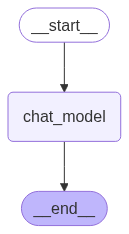

In [ ]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    # 使用 trim_messages 函数修剪消息列表
    # max_tokens: 限制消息的最大令牌数
    # strategy: 修剪策略，这里是“last”，表示保留最新的消息
    # token_counter: 用于计算令牌数的模型实例
    # allow_partial: 是否允许部分修剪
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter= ChatOpenAI(
                model="qwen-plus-2025-04-28",
                api_key="sk-ba2dda3817f145d7af141fdf32e31d90",
                base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"),
            allow_partial=False,
        )
    # 调用语言模型（llm）处理修剪后的消息，并返回结果
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"告诉我虎鲸住在哪里！", name="Lance"))

In [17]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', name='Lance')]

In [17]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

NotImplementedError: get_num_tokens_from_messages() is not presently implemented for model qwen-plus-2025-04-28. See https://platform.openai.com/docs/guides/text-generation/managing-tokens for information on how messages are converted to tokens.

Let's look at the LangSmith trace to see the model invocation:
https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r

